In [1]:
import os
# Disable tokenizers parallelism
# os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-4y5jd6fn
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-4y5jd6fn
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=1248f5fb4455b5a0fd4058e6acdd7e964e9cd939d9065db84f726b192e05bea8
  Stored in directory: /tmp/pip-ephem-wheel-cache-xa739cch/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=em

In [3]:
import pandas as pd
from collections import Counter
import re
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
from datasets import load_metric
import datasets
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from datasets import Dataset, DatasetDict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import random
np.object = object
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding,BertModel,AutoTokenizer,AutoConfig,RobertaModel
from collections import defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from sklearn.model_selection import KFold
from torch.cuda import amp

import gc
gc.enable()

2025-02-25 17:30:47.150892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 17:30:47.151009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 17:30:47.309246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_csv("/kaggle/input/bengali-pharmaceutical-reviews/LargePharmaVal.csv")

In [6]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=10))

,Reviews,category,Label,Length,Word Count
438,ডেলিভারি ম্যান একটু দেরী করেছে। সাপ্লিমেন্ট এর মোটামুটি ঠিক আছে,body_fitness,3,63,10
6933,কনডম কেনা আমার জীবনের সবচেয়ে বড় ভুল। এক্সপায়ারি ডেট মুছে ফেলা ☹️☹️ একদম ঠকবাজ সেলার,adult_items,1,86,15
4252,শ্যাম্পু কেনা আমার জীবনের সবচেয়ে বড় ভুল। বাজে কোয়ালিটি 😡😡,womens_item,1,60,10
128,সাপ্লিমেন্ট কিনে খুব অনুতপ্ত। ফেক প্রোডাক্ট 😭😭 লোকাল মার্কেটে 372 টাকা কম,body_fitness,1,73,12
6086,হাপাতালের নার্স আপার পরামর্শে এই ডায়াপার অর্ডার করেছি। এটা দিয়ে বেবি কমফোর্ট ফিল করছে না কেন? এটা সম্ভবত সেলার যে কিনা দুই নাম্বার মাল দিয়েছে। \nআজকাল তো সব কিছুরই নকল হয়।,baby_items,2,171,31
1422,ধন্যবাদ সেলার কে। সত্যি বেশ ভালোই প্রোডাক্ট গুলো ব্যবহার করে রিভিউ দিলাম। এখন আরো কিছুদিন ব্যবহার করে ফাইনালে রিভিউ দিবো। বলা তো যায় না কতদিন যাবে,womens_item,4,146,26
3286,মাস্কগুলো তিন লেয়ার আছে। ব্রেথিং প্রবলেম হয় না। নোজবার আছে। ইয়ার লুপটা একটু লুজ হয়। তাই ঢিলা থাকে সামান্য। \nতবে ওভারঅল চালিয়ে নেয়ার মতন এই দামে। আশা থাকবে সামনাই আরো ভালো কোয়ালিটি নিয়ে আসবেন।,medical_kits,4,192,34
1341,ভাই আমার অক্সিমিটার তো চলেই না। কি দিলেন 😤😌। আশা করলাম কি আর হলো কি! নকল মাল দিয়ে মানুষ ঠকিয়ে আপনারা কি আগাতে পারবেন। বিচার হবে।,Random/Misc,1,128,26
6954,"রেগুলার পানি গরম করে শেক দিতে পারবেন এটা দিয়ে। আমি কিনছিলাম ২ সপ্তাহ হলো। সেলার বললেন হিট হবে প্রায় ৯০ ডিগ্রি, কিন্তু শালা কি কপাল এখন অল্প সময় পরেই ঠান্ডা হয়ে যাচ্ছে।",medical_kits,3,168,32
8475,ধান্দাবাজ প্রতারক সেলারদের জন্য আর মনে হয় অনলাইনে মেডিসিন ক্রয় করা সম্ভব হবে না। স্যালাইন এর প্যাকেটে পোকা পড়ে আছে 😠😠। এসএমসি এর স্যালাইন এর জায়গায় একটা ফালতু কোম্পানির মাল দিয়েছে। এসব তো হবেই!,medicines,1,193,34


In [7]:
df.shape

(9515, 5)

In [8]:
df.shape[0]*0.7

6660.5

In [9]:
df["Label"].value_counts()

Label
5    2238
1    2199
4    1989
2    1563
3    1526
Name: count, dtype: int64

In [10]:
df["Label"] = df["Label"] - 1  # Shift labels to be zero-indexed
df["Label"].value_counts()

Label
4    2238
0    2199
3    1989
1    1563
2    1526
Name: count, dtype: int64

In [11]:
print(df["Label"].unique())  

[0 3 4 1 2]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title):
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(df))
    
    # Sort the values by index (class names)
    ordered_counts = df[col].value_counts().sort_index()
    
    ax = sns.countplot(x=col, data=df, order=ordered_counts.iloc[:top_x].index)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    
    plt.xticks(rotation=rotation,weight='bold',size=10)
    plt.yticks(weight='bold',size=10)
    plt.xlabel(xlabel,weight='bold',size=12)
    plt.ylabel('Number of Samples',weight='bold',size=12)
    plt.title(title,weight='bold',size=15)
    plt.show()

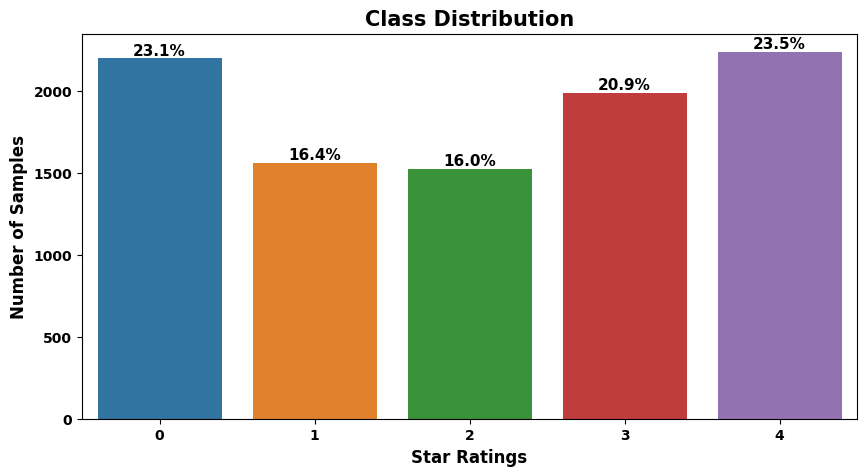

In [13]:
countplot(10,5,'Label',15,0,'Star Ratings','Class Distribution')

In [14]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into train and temp (test + validation) sets
X_train, X_test1, y_train, y_test1 = train_test_split(df['Reviews'], df['Label'], test_size=0.3, random_state=42, stratify=df['Label'])

# Step 2: Split the temp set into validation and test sets (10% validation, 20% test)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=2/3, random_state=42, stratify=y_test1)

In [15]:
X_train.shape

(6660,)

In [16]:
train_df = pd.DataFrame()
train_df['text'] = X_train.values
train_df['label'] = y_train.values


In [17]:
val_df = pd.DataFrame()
val_df['text'] = X_val.values
val_df['label'] = y_val.values

In [18]:
test_df = pd.DataFrame()
test_df['text'] = X_test.values
test_df['label'] = y_test.values

In [19]:
train_df.shape

(6660, 2)

In [20]:
train_df.head()

,text,label
0,১০০% অরিজিনাল প্রোডাক্ট! খুব উন্নত মানের প্রোড...,4
1,আলহামদুলিল্লাহ অনেক অনেক ভালো লেগেছে 😍। সুন্দর...,4
2,প্রথম প্রথম ব্যবহার করে খুব ভালো ফল পেয়েছিলাম ...,2
3,অসংখ্য ধন্যবাদ সেলারকে। তিনি কারেন্ট ডেটের এবং...,4
4,৫০ টা মাস্কের অনেক গুলায় নাকে ফিট করার স্টিল ট...,2


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1904 non-null   object
 1   label   1904 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.9+ KB


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplotTrain(fig_x,fig_y,col,top_x,rotation,xlabel,title):
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    
    # Sort the values by index (class names)
    ordered_counts = train_df[col].value_counts().sort_index()
    
    ax = sns.countplot(x=col, data=train_df, order=ordered_counts.iloc[:top_x].index)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    
    plt.xticks(rotation=rotation,weight='bold',size=10)
    plt.yticks(weight='bold',size=10)
    plt.xlabel(xlabel,weight='bold',size=12)
    plt.ylabel('Number of Samples',weight='bold',size=12)
    plt.title(title,weight='bold',size=15)
    plt.show()

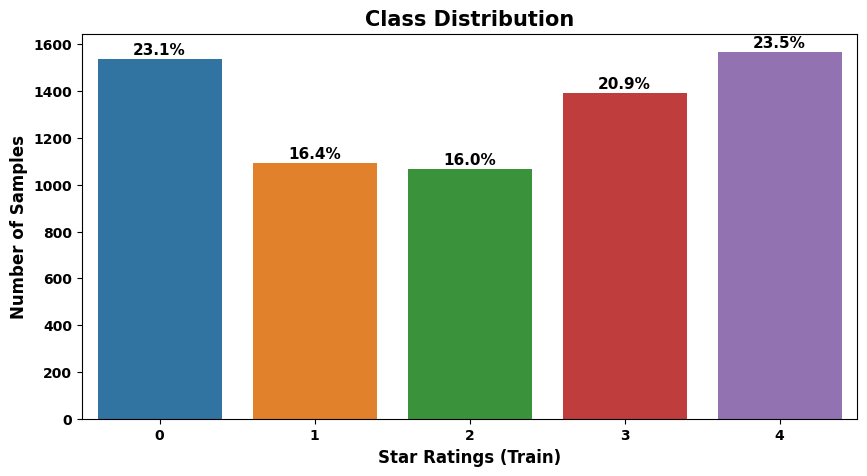

In [23]:
countplotTrain(10,5,'label',15,0,'Star Ratings (Train)','Class Distribution')

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplotVal(fig_x,fig_y,col,top_x,rotation,xlabel,title):
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    
    # Sort the values by index (class names)
    ordered_counts = train_df[col].value_counts().sort_index()
    
    ax = sns.countplot(x=col, data=train_df, order=ordered_counts.iloc[:top_x].index)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    
    plt.xticks(rotation=rotation,weight='bold',size=10)
    plt.yticks(weight='bold',size=10)
    plt.xlabel(xlabel,weight='bold',size=12)
    plt.ylabel('Number of Samples',weight='bold',size=12)
    plt.title(title,weight='bold',size=15)
    plt.show()

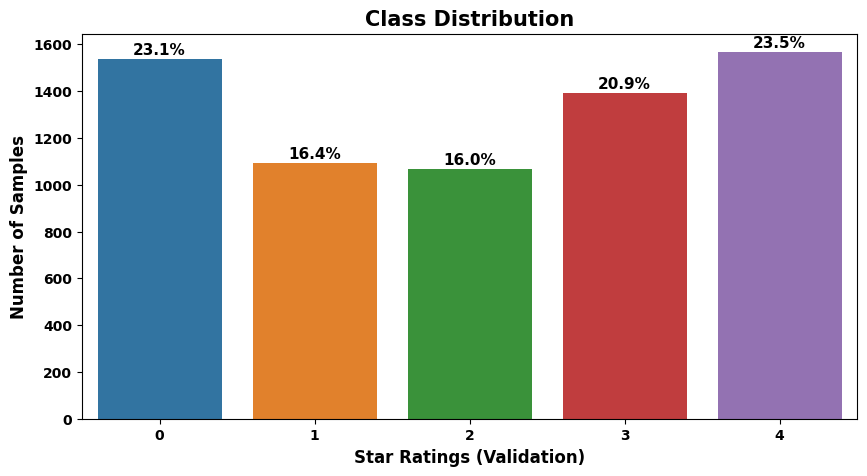

In [25]:
countplotVal(10,5,'label',15,0,'Star Ratings (Validation)','Class Distribution')

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplotTest(fig_x,fig_y,col,top_x,rotation,xlabel,title):
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    
    # Sort the values by index (class names)
    ordered_counts = train_df[col].value_counts().sort_index()
    
    ax = sns.countplot(x=col, data=train_df, order=ordered_counts.iloc[:top_x].index)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    
    plt.xticks(rotation=rotation,weight='bold',size=10)
    plt.yticks(weight='bold',size=10)
    plt.xlabel(xlabel,weight='bold',size=12)
    plt.ylabel('Number of Samples',weight='bold',size=12)
    plt.title(title,weight='bold',size=15)
    plt.show()

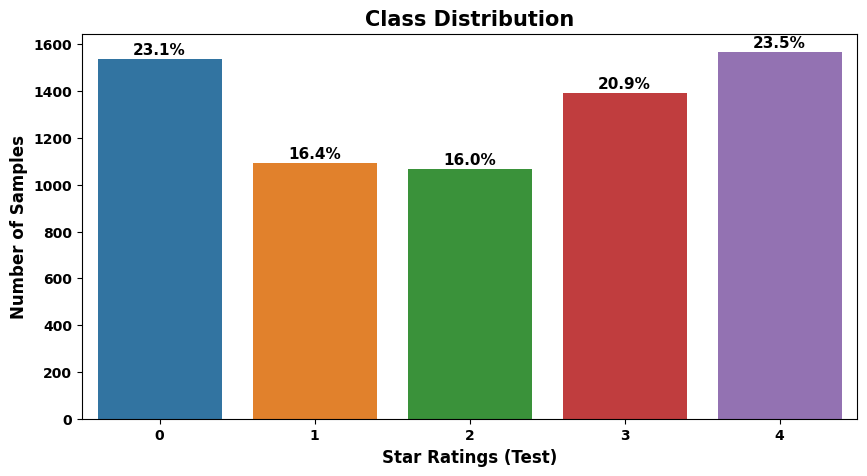

In [27]:
countplotTest(10,5,'label',15,0,'Star Ratings (Test)','Class Distribution')

In [28]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [29]:
class Config:
    num_classes = 5
    path =  "monsoon-nlp/bangla-electra" 
    num_epochs = 10
    batch_size = 32
    SEED = 42
    learning_rate = 2e-5
    device = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

In [30]:
tokenizer = AutoTokenizer.from_pretrained(config.path)

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/391 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/492k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<Axes: ylabel='Count'>

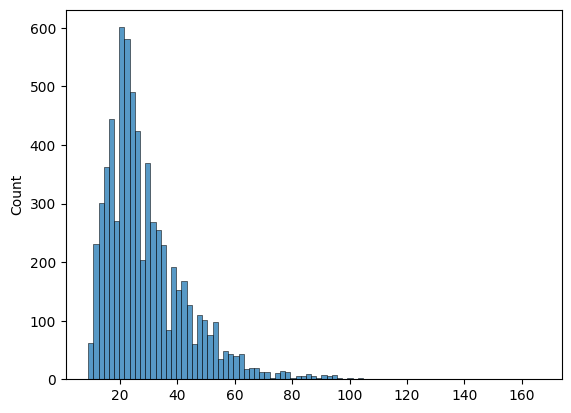

In [31]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

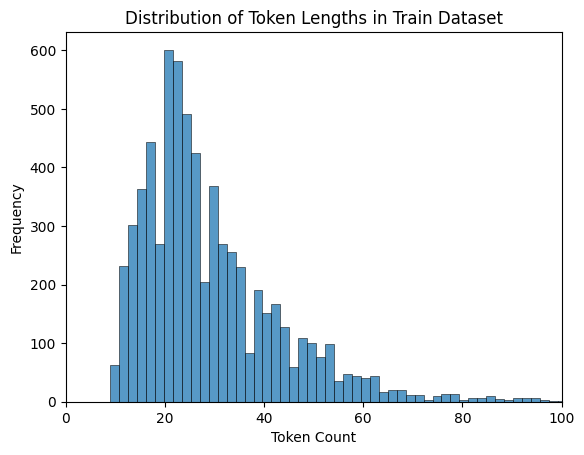

In [32]:
sns.histplot(token_counts)
plt.xlim([0, 100]);

# Label axes and add title
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths in Train Dataset")

# Caption: This histogram shows the distribution of token lengths in the validation dataset after tokenization.
plt.show()

In [33]:
train_token = max(token_counts)
train_token

166

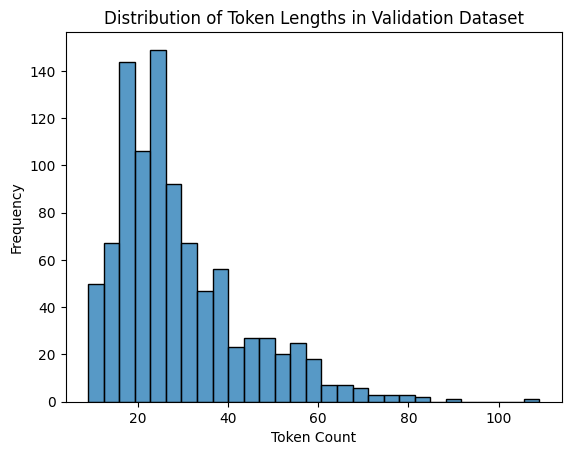

In [34]:
token_counts = []
for _, row in val_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

# Label axes and add title
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths in Validation Dataset")

# Caption: This histogram shows the distribution of token lengths in the validation dataset after tokenization.
plt.show()

In [35]:
val_token = max(token_counts)
val_token

109

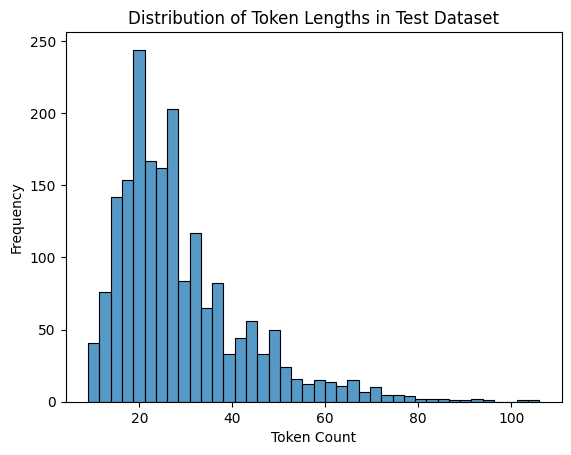

In [36]:
token_counts = []
for _, row in test_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

# Label axes and add title
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths in Test Dataset")

# Caption: This histogram shows the distribution of token lengths in the validation dataset after tokenization.
plt.show()

In [37]:
test_token = max(token_counts)
test_token

106

In [38]:
max_token_length = max(train_token, val_token, test_token) + 10
def tokenize_function(example):
    return tokenizer(example["text"], padding = True, truncation=True, max_length=max_token_length)

# mapping dataset (actually texts) into tokenized values of pretrained model (provided in path)
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6660 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

In [39]:
max_token_length

176

In [40]:
tokenized_train_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6660
})

In [41]:
tokenized_val_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 951
})

In [42]:
tokenized_test_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1904
})

In [43]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_test_datasets = tokenized_test_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_train_datasets.set_format("torch")
tokenized_val_datasets.set_format("torch")
tokenized_test_datasets.set_format("torch")

In [44]:
tokenized_test_datasets.column_names

['label', 'input_ids', 'attention_mask']

In [45]:
# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.bert = BertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes)

#     def forward(self, input_ids, attention_mask):
#         output = self.bert(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         x = self.drop(output[1])

#         return self.out(x)

# '''XLM-R Model'''
# from transformers import XLNetModel, XLNetTokenizer

# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.xlnet = XLNetModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.30)
#         self.out = nn.Linear(768, config.num_classes)  

#     def forward(self, input_ids, attention_mask):
#         # XLNet returns two outputs: the last hidden state and the pooled output (similar to BERT)
#         output = self.xlnet(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         # Take the first token's representation
#         cls_output = output.last_hidden_state[:, 0, :]  
#         x = self.drop(cls_output)

#         return self.out(x)


# '''ALBert Model'''
# from transformers import AlbertModel


# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.albert = AlbertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes) 

#     def forward(self, input_ids, attention_mask):
#         output = self.albert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )

#         pooled_output = output[1]  
#         x = self.drop(pooled_output)

#         return self.out(x)


# '''mBERT Model'''
# class ClassifierModel(nn.Module):
#     def __init__(self, config):
#         super(ClassifierModel, self).__init__()
#         self.bert = BertModel.from_pretrained(config.path)
#         self.dropout = nn.Dropout(p=0.3)
#         self.fc = nn.Linear(768, config.num_classes) 

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
        
#         pooled_output = outputs[1]
#         x = self.dropout(pooled_output)

#         return self.fc(x)

from transformers import ElectraModel, ElectraTokenizer
from transformers import AutoModel

'''Bangla-ELectra Model'''
class ClassifierModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.electra = AutoModel.from_pretrained(config.path)  # using config.path instead of model_name
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(self.electra.config.hidden_size, config.num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        x = outputs.last_hidden_state[:, 0, :]  # Get the [CLS] token embedding
        x = self.dropout(x)
        return self.out(x)

In [46]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score


class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        DEVICE = config.device
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(DEVICE)
            attention_mask = data["attention_mask"].to(DEVICE)            
            target = data["labels"].to(DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        DEVICE = config.device
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(DEVICE)
                attention_mask = data["attention_mask"].to(DEVICE)            
                target = data["labels"].to(DEVICE)
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [47]:
from transformers import get_scheduler

def run_training(save_model = False):

    train_loader = DataLoader(tokenized_train_datasets, batch_size = config.batch_size,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(tokenized_val_datasets, batch_size = config.batch_size,
                            drop_last=False,collate_fn=data_collator, shuffle=False, num_workers=2)   
    set_random_seed(config.SEED)
    model = ClassifierModel(config)
    model.to(config.device)
    
#     optimizer = create_optimizer(model)  
    optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate, weight_decay=0.01)
    # optimizer = torch.optim.RAdam(model.parameters(), lr=config.learning_rate, weight_decay=0.01)
    num_training_steps = config.num_epochs * len(train_loader)
    
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.num_epochs):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Val_loss: {round(val_loss,5)} | Val_Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            
            if save_model:
                torch.save(model.state_dict(),f"bangla_electra_model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [48]:
score = run_training(save_model = True)
print(f"Best Score: {score}")

model.safetensors:   0%|          | 0.00/53.9M [00:00<?, ?B/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 1 | Training_loss: 1.4345 | Val_loss: 1.19457 | Val_Score: 0.478


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 2 | Training_loss: 1.07896 | Val_loss: 0.83437 | Val_Score: 0.66948


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 3 | Training_loss: 0.8055 | Val_loss: 0.66153 | Val_Score: 0.71705


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e5441f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 4 | Training_loss: 0.65937 | Val_loss: 0.59605 | Val_Score: 0.74475


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 5 | Training_loss: 0.57199 | Val_loss: 0.52159 | Val_Score: 0.78634


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11e5441f30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 6 | Training_loss: 0.51997 | Val_loss: 0.50038 | Val_Score: 0.79824


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 7 | Training_loss: 0.47624 | Val_loss: 0.48247 | Val_Score: 0.79564


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Exception ignored in: <funct

  0%|          | 0/30 [00:00<?, ?it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 8 | Training_loss: 0.45387 | Val_loss: 0.47846 | Val_Score: 0.80591


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 9 | Training_loss: 0.42947 | Val_loss: 0.46783 | Val_Score: 0.80973


  0%|          | 0/2090 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/30 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Epoch: 10 | Training_loss: 0.42386 | Val_loss: 0.46382 | Val_Score: 0.8155
Best Score: 0.8154955243586824


In [49]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)

In [50]:
device = config.device

In [51]:
model = ClassifierModel(config)

In [52]:
model_path = f"/kaggle/working/bangla_electra_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [53]:
model.to(device)

ClassifierModel(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(29898, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=

In [54]:
model.eval()
prediction = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
        logits = outputs
        pred = torch.argmax(logits, dim=-1)
        prediction.extend(pred.cpu().numpy().tolist())

In [55]:
y_true = test_df.label.values
y_pred = prediction

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_true, y_pred))

[[393  29   8   6   4]
 [ 17 251  41   3   1]
 [  7  54 215  27   2]
 [  4  10  51 324   9]
 [  9   0   4  19 416]]


In [57]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

print("Model: BanElectra")

# Print metrics
print("Weighted F1 Score:", weighted_f1)
print("Macro F1 Score:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Macro Precision:", macro_precision)
print("Weighted Recall:", weighted_recall)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       440
           1       0.73      0.80      0.76       313
           2       0.67      0.70      0.69       305
           3       0.85      0.81      0.83       398
           4       0.96      0.93      0.95       448

    accuracy                           0.84      1904
   macro avg       0.83      0.83      0.83      1904
weighted avg       0.84      0.84      0.84      1904

Confusion Matrix:
 [[393  29   8   6   4]
 [ 17 251  41   3   1]
 [  7  54 215  27   2]
 [  4  10  51 324   9]
 [  9   0   4  19 416]]
Model: BanElectra
Weighted F1 Score: 0.8415633996473616
Macro F1 Score: 0.8272122734073608
Weighted Precision: 0.8443985103103072
Macro Precision: 0.8270860143678179
Weighted Recall: 0.8398109243697479
Macro Recall: 0.8285317128412549
Accuracy: 0.8398109243697479


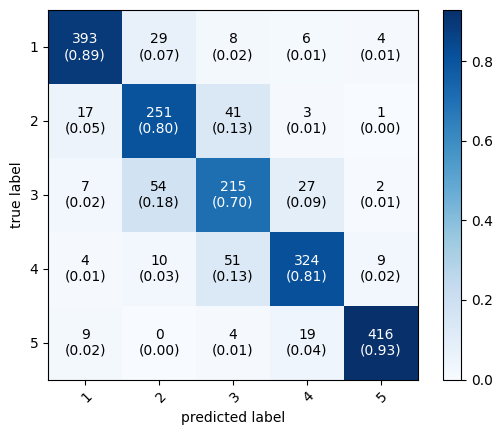

In [58]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes=5)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=[1,2,3,4,5],
                                show_normed=True,
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()